<a href="https://colab.research.google.com/github/mmarin11/Colabfiles/blob/main/Avance_de_proyecto_Aplicacion_de_regresion_Lineal%2C_Ridge_y_Lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Github link

In [87]:

# ============================================================================
# CARGA DE LIBRERIAS
# ============================================================================
print("=" * 100)
print("PASO 0: IMPORTANDO LIBRERÍAS")
print("=" * 100)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
from scipy.stats import shapiro, jarque_bera,normaltest
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

print("✓ Librerías importadas exitosamente\n")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



PASO 0: IMPORTANDO LIBRERÍAS
✓ Librerías importadas exitosamente



# Carga de informacion y procesamiento inicial


CARGA Y EXPLORACIÓN INICIAL DE DATOS

Dimensiones del dataset: (1460, 81)
Número de filas: 1460
Número de columnas: 81

--- Información general del dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non

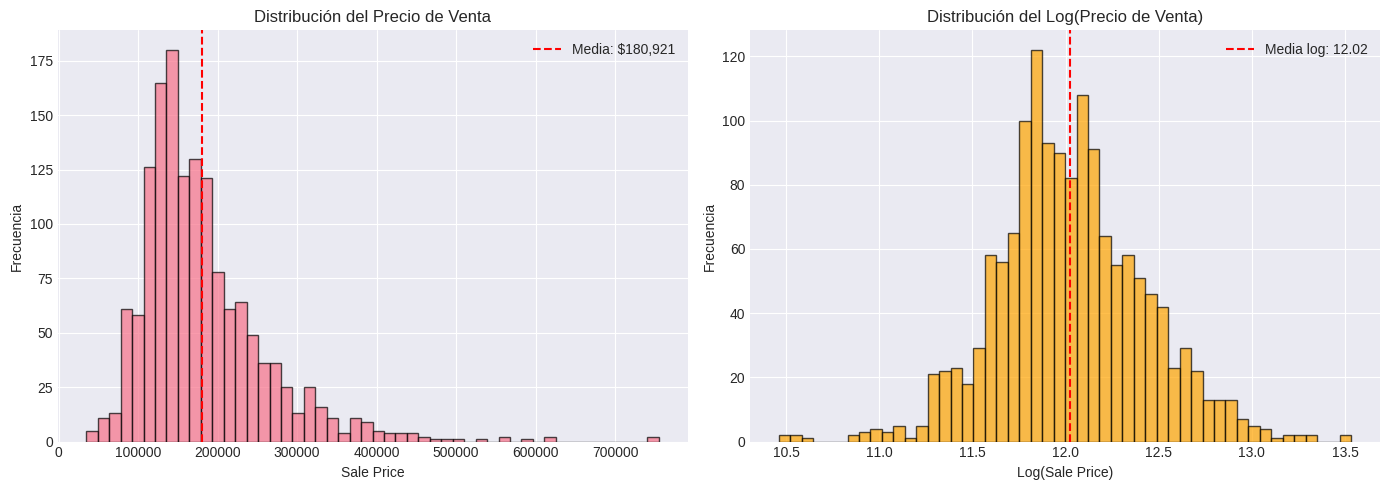

In [89]:
print("\n" + "=" * 80)
print("CARGA Y EXPLORACIÓN INICIAL DE DATOS")
print("=" * 80)

df = pd.read_csv('/content/sample_data/data.csv')
print(f"\nDimensiones del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

print("\n--- Información general del dataset ---")
print(df.info())

print("\n--- Primeras filas ---")
print(df.head())

print("\n--- Estadísticas descriptivas de la variable objetivo (SalePrice) ---")
print(df['SalePrice'].describe())

# Visualizar distribución del precio
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sale Price')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución del Precio de Venta')
axes[0].axvline(df['SalePrice'].mean(), color='red', linestyle='--', label=f'Media: ${df["SalePrice"].mean():,.0f}')
axes[0].legend()

axes[1].hist(np.log1p(df['SalePrice']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Log(Sale Price)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución del Log(Precio de Venta)')
axes[1].axvline(np.log1p(df['SalePrice']).mean(), color='red', linestyle='--', label=f'Media log: {np.log1p(df["SalePrice"]).mean():.2f}')
axes[1].legend()

plt.tight_layout()

#Analisis de valores nulos y estrategia de imputacion

In [91]:
print("\n" + "=" * 80)
print("PREPROCESAMIENTO DE DATOS")
print("=" * 80)

# Crear copia para trabajar
df_processed = df.copy()

# --- Convertir MSSubClass a categórica ---
print("\n--- 3.1. Convirtiendo MSSubClass a categórica ---")
print(f"Tipo original de MSSubClass: {df_processed['MSSubClass'].dtype}")
print(f"Valores únicos: {df_processed['MSSubClass'].nunique()}")
print(f"Valores: {sorted(df_processed['MSSubClass'].unique())}")

# Mapeo de códigos a descripciones
mssubclass_mapping = {
    20: '1-STORY 1946 & NEWER ALL STYLES',
    30: '1-STORY 1945 & OLDER',
    40: '1-STORY W/FINISHED ATTIC ALL AGES',
    45: '1-1/2 STORY - UNFINISHED ALL AGES',
    50: '1-1/2 STORY FINISHED ALL AGES',
    60: '2-STORY 1946 & NEWER',
    70: '2-STORY 1945 & OLDER',
    75: '2-1/2 STORY ALL AGES',
    80: 'SPLIT OR MULTI-LEVEL',
    85: 'SPLIT FOYER',
    90: 'DUPLEX - ALL STYLES AND AGES',
    120: '1-STORY PUD - 1946 & NEWER',
    150: '1-1/2 STORY PUD - ALL AGES',
    160: '2-STORY PUD - 1946 & NEWER',
    180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
    190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
}

# Convertir a string para tratarlo como categórico
df_processed['MSSubClass'] = df_processed['MSSubClass'].astype(str)
print(f"Tipo después de conversión: {df_processed['MSSubClass'].dtype}")

# --- Identificar tipos de variables ---
print("\n--- 3.2. Identificación de tipos de variables ---")

# Separar variable objetivo
y = df_processed['SalePrice']
X = df_processed.drop(['Id', 'SalePrice'], axis=1)

# Identificar variables numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nVariables numéricas: {len(numeric_features)}")
print(f"Variables categóricas: {len(categorical_features)}")

# --- 3.3. Análisis de cardinalidad para variables categóricas ---
print("\n--- Análisis de cardinalidad de variables categóricas ---")

# Calcular cardinalidad
cardinality = {}
for col in categorical_features:
    cardinality[col] = X[col].nunique()

cardinality_df = pd.DataFrame.from_dict(cardinality, orient='index', columns=['Cardinalidad'])
cardinality_df = cardinality_df.sort_values('Cardinalidad', ascending=False)

print("\nCardinalidad de variables categóricas:")
print(cardinality_df)

# Clasificar por cardinalidad
high_cardinality_features = cardinality_df[cardinality_df['Cardinalidad'] > 10].index.tolist()
low_cardinality_features = cardinality_df[cardinality_df['Cardinalidad'] <= 10].index.tolist()

print(f"\n✓ Variables de ALTA cardinalidad (>10): {len(high_cardinality_features)}")
print(f"  {high_cardinality_features}")
print(f"\n✓ Variables de BAJA cardinalidad (≤10): {len(low_cardinality_features)}")
print(f"  {low_cardinality_features}")

# --- 3.4. Identificar variables "No Aplicables" ---
print("\n--- Variables con significado 'No Aplicable' para NaN ---")

# Variables donde NaN significa "No tiene/No aplica"
na_means_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                         'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                         'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                         'PoolQC', 'Fence', 'MiscFeature']

print("Variables donde NaN = 'No tiene/No aplica':")
for var in na_means_missing_vars:
    if var in X.columns:
        null_count = X[var].isnull().sum()
        null_pct = (null_count / len(X)) * 100
        print(f"  - {var}: {null_count} nulos ({null_pct:.1f}%)")


PREPROCESAMIENTO DE DATOS

--- 3.1. Convirtiendo MSSubClass a categórica ---
Tipo original de MSSubClass: int64
Valores únicos: 15
Valores: [np.int64(20), np.int64(30), np.int64(40), np.int64(45), np.int64(50), np.int64(60), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(120), np.int64(160), np.int64(180), np.int64(190)]
Tipo después de conversión: object

--- 3.2. Identificación de tipos de variables ---

Variables numéricas: 35
Variables categóricas: 44

--- Análisis de cardinalidad de variables categóricas ---

Cardinalidad de variables categóricas:
               Cardinalidad
Neighborhood             25
Exterior2nd              16
Exterior1st              15
MSSubClass               15
Condition1                9
SaleType                  9
HouseStyle                8
RoofMatl                  8
Condition2                8
Functional                7
BsmtFinType2              6
RoofStyle                 6
BsmtFinType1              6
SaleCondition   

# Imputacion de valores nulos

In [94]:
# ============================================================================
# ESTRATEGIA DE IMPUTACIÓN
# ============================================================================
print("\n" + "=" * 80)
print("4. ESTRATEGIA DE IMPUTACIÓN")
print("=" * 80)

"""
EXPLICACIÓN DE LA ESTRATEGIA DE IMPUTACIÓN:

1. Variables categóricas con NaN = "No aplica":
   - Se imputan con 'Missing' para preservar esta información
   - Ejemplo: Alley=NaN significa "no tiene callejón"

2. Variables categóricas regulares:
   - Se imputan con la moda (valor más frecuente)

3. Variables numéricas:
   - Se imputan con la mediana (más robusta a outliers que la media)

4. Variables relacionadas con garaje:
   - GarageYrBlt: Si es nulo, probablemente no hay garaje → imputar con 0
"""

X_imputed = X.copy()

# Imputar variables categóricas "No Aplicables" con 'Missing'
print("\n--- Imputando variables categóricas 'No Aplicables' ---")
for col in na_means_missing_vars:
    if col in X_imputed.columns:
        before = X_imputed[col].isnull().sum()
        X_imputed[col] = X_imputed[col].fillna('Missing')
        print(f"  {col}: {before} → 0 nulos (imputado con 'Missing')")

# Imputar variables categóricas restantes con moda
print("\n--- Imputando variables categóricas restantes con moda ---")
remaining_cat_features = [col for col in categorical_features if col not in na_means_missing_vars]
for col in remaining_cat_features:
    if col in X_imputed.columns and X_imputed[col].isnull().sum() > 0:
        before = X_imputed[col].isnull().sum()
        mode_value = X_imputed[col].mode()[0]
        X_imputed[col] = X_imputed[col].fillna(mode_value)
        print(f"  {col}: {before} → 0 nulos (imputado con moda: '{mode_value}')")

# Imputar variables numéricas con mediana
print("\n--- Imputando variables numéricas con mediana ---")
for col in numeric_features:
    if col in X_imputed.columns and X_imputed[col].isnull().sum() > 0:
        before = X_imputed[col].isnull().sum()
        median_value = X_imputed[col].median()
        X_imputed[col] = X_imputed[col].fillna(median_value)
        print(f"  {col}: {before} → 0 nulos (imputado con mediana: {median_value:.2f})")

# Verificar que no queden nulos
print(f"\n✓ Valores nulos restantes: {X_imputed.isnull().sum().sum()}")


4. ESTRATEGIA DE IMPUTACIÓN

--- Imputando variables categóricas 'No Aplicables' ---
  Alley: 1369 → 0 nulos (imputado con 'Missing')
  BsmtQual: 37 → 0 nulos (imputado con 'Missing')
  BsmtCond: 37 → 0 nulos (imputado con 'Missing')
  BsmtExposure: 38 → 0 nulos (imputado con 'Missing')
  BsmtFinType1: 37 → 0 nulos (imputado con 'Missing')
  BsmtFinType2: 38 → 0 nulos (imputado con 'Missing')
  FireplaceQu: 690 → 0 nulos (imputado con 'Missing')
  GarageType: 81 → 0 nulos (imputado con 'Missing')
  GarageFinish: 81 → 0 nulos (imputado con 'Missing')
  GarageQual: 81 → 0 nulos (imputado con 'Missing')
  GarageCond: 81 → 0 nulos (imputado con 'Missing')
  PoolQC: 1453 → 0 nulos (imputado con 'Missing')
  Fence: 1179 → 0 nulos (imputado con 'Missing')
  MiscFeature: 1406 → 0 nulos (imputado con 'Missing')

--- Imputando variables categóricas restantes con moda ---
  MasVnrType: 872 → 0 nulos (imputado con moda: 'BrkFace')
  Electrical: 1 → 0 nulos (imputado con moda: 'SBrkr')

--- Imputa

#Encoding para encoding de variables categoricas

In [102]:
# ============================================================================
# ENCODING DE VARIABLES CATEGÓRICAS
# ============================================================================
print("\n" + "=" * 80)
print("ENCODING DE VARIABLES CATEGÓRICAS")
print("=" * 80)

"""
EXPLICACIÓN DE LA ESTRATEGIA DE ENCODING:

1. ONE-HOT ENCODING (para baja cardinalidad ≤10):
   - Crea una columna binaria para cada categoría
   - Ventajas: Simple, no asume orden en las categorías
   - Desventajas: Aumenta dimensionalidad
   - Ejemplo: Si 'Street' tiene ['Pave', 'Gravel'] → 2 columnas

2. TARGET ENCODING (para alta cardinalidad >10):
   - Reemplaza cada categoría con el promedio del target para esa categoría
   - Ventajas: No aumenta dimensionalidad, captura relación con target
   - Desventajas: Puede causar overfitting, requiere validación cruzada
   - Ejemplo: Si 'Neighborhood'='CollgCr' tiene precio promedio $200k → 200000

IMPORTANTE: Target encoding se hace solo en train set para evitar data leakage
"""

# Dividir datos antes del encoding para evitar data leakage
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

print(f"\nConjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

# Target Encoding para variables de alta cardinalidad
print("\n--- Target Encoding (alta cardinalidad >10) ---")

def target_encode(train_df, test_df, target, columns):
    """
    Aplica target encoding a las columnas especificadas
    """
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    encoding_maps = {}

    # Crear DataFrame temporal con target para facilitar groupby
    temp_train = train_encoded.copy()
    temp_train['__target__'] = target.values

    for col in columns:
        # Calcular medias por categoría en train
        means = temp_train.groupby(col)['__target__'].mean()
        global_mean = target.mean()

        # Guardar mapeo
        encoding_maps[col] = means

        # Aplicar encoding
        train_encoded[col + '_encoded'] = train_df[col].map(means)
        test_encoded[col + '_encoded'] = test_df[col].map(means)

        # Rellenar valores no vistos con media global
        train_encoded[col + '_encoded'] = train_encoded[col + '_encoded'].fillna(global_mean)
        test_encoded[col + '_encoded'] = test_encoded[col + '_encoded'].fillna(global_mean)

        # Eliminar columna original
        train_encoded = train_encoded.drop(col, axis=1)
        test_encoded = test_encoded.drop(col, axis=1)

        print(f"  {col}: {len(means)} categorías → 1 feature numérica")

    return train_encoded, test_encoded, encoding_maps

# Aplicar target encoding
X_train_encoded, X_test_encoded, target_encoding_maps = target_encode(
    X_train, X_test, y_train, high_cardinality_features
)

# One-Hot Encoding para variables de baja cardinalidad
print("\n--- One-Hot Encoding (baja cardinalidad ≤10) ---")

# Aplicar one-hot encoding
X_train_ohe = pd.get_dummies(X_train_encoded, columns=low_cardinality_features, drop_first=True)
X_test_ohe = pd.get_dummies(X_test_encoded, columns=low_cardinality_features, drop_first=True)

# Asegurar que ambos conjuntos tengan las mismas columnas
missing_cols = set(X_train_ohe.columns) - set(X_test_ohe.columns)
for col in missing_cols:
    X_test_ohe[col] = 0

extra_cols = set(X_test_ohe.columns) - set(X_train_ohe.columns)
for col in extra_cols:
    X_test_ohe = X_test_ohe.drop(col, axis=1)

X_test_ohe = X_test_ohe[X_train_ohe.columns]

print(f"\n✓ Variables después de encoding:")
print(f"  Entrenamiento: {X_train_ohe.shape}")
print(f"  Prueba: {X_test_ohe.shape}")
print(f"  Total de features: {X_train_ohe.shape[1]}")


ENCODING DE VARIABLES CATEGÓRICAS

Conjunto de entrenamiento: (1168, 79)
Conjunto de prueba: (292, 79)

--- Target Encoding (alta cardinalidad >10) ---
  Neighborhood: 25 categorías → 1 feature numérica
  Exterior2nd: 16 categorías → 1 feature numérica
  Exterior1st: 15 categorías → 1 feature numérica
  MSSubClass: 15 categorías → 1 feature numérica

--- One-Hot Encoding (baja cardinalidad ≤10) ---

✓ Variables después de encoding:
  Entrenamiento: (1168, 206)
  Prueba: (292, 206)
  Total de features: 206


#Escalacion de variables


ESCALACIÓN DE VARIABLES

✓ Escalación completada
Media de features escaladas: 0.000000
Desviación estándar de features escaladas: 1.000428


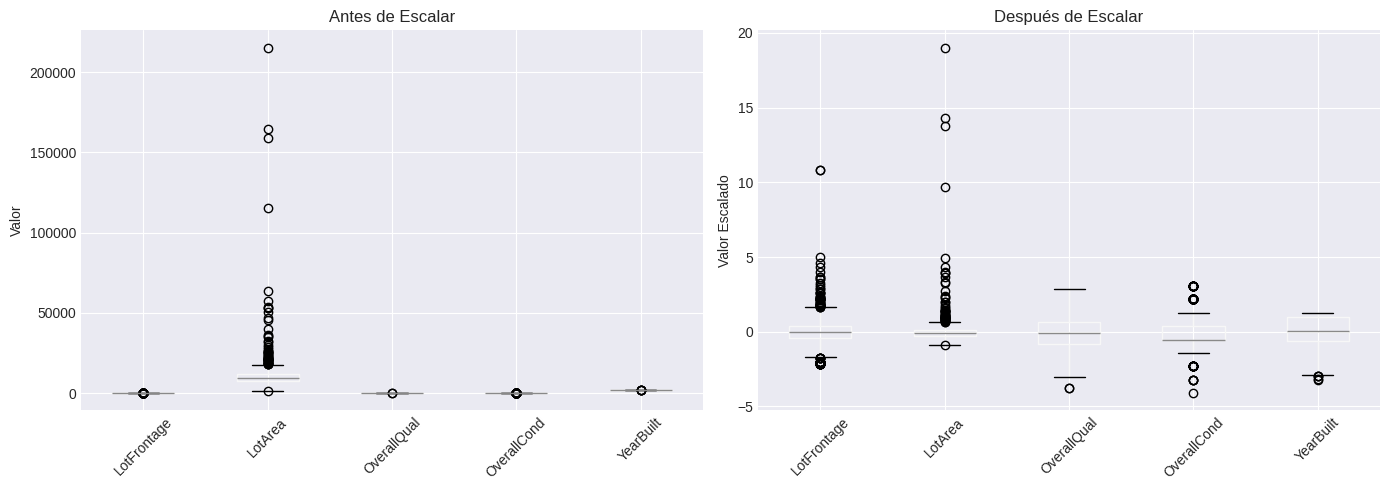

In [105]:
# ============================================================================
# ESCALACIÓN DE VARIABLES
# ============================================================================
print("\n" + "=" * 80)
print("ESCALACIÓN DE VARIABLES")
print("=" * 80)

"""
EXPLICACIÓN DE LA ESCALACIÓN (StandardScaler):

StandardScaler transforma las variables para que tengan:
- Media = 0
- Desviación estándar = 1

Fórmula: z = (x - μ) / σ

Donde:
- x = valor original
- μ = media
- σ = desviación estándar
- z = valor escalado

¿Por qué es importante?
1. Los algoritmos de regresión (especialmente Ridge y Lasso) son sensibles a la escala
2. Variables con escalas diferentes pueden dominar el modelo
3. Facilita la interpretación de coeficientes regularizados

Ejemplo:
- LotArea (pies cuadrados): rango [1,300 - 215,245]
- OverallQual (calidad): rango [1 - 10]
Sin escalar, LotArea dominaría el modelo por su magnitud
"""

# Escalar todas las features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)

# Convertir de vuelta a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_ohe.columns, index=X_train_ohe.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_ohe.columns, index=X_test_ohe.index)

print("\n✓ Escalación completada")
print(f"Media de features escaladas: {X_train_scaled.mean().mean():.6f}")
print(f"Desviación estándar de features escaladas: {X_train_scaled.std().mean():.6f}")

# Visualizar efecto de escalación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes de escalar
sample_features = X_train_ohe.select_dtypes(include=[np.number]).columns[:5]
X_train_ohe[sample_features].boxplot(ax=axes[0])
axes[0].set_title('Antes de Escalar')
axes[0].set_ylabel('Valor')
axes[0].tick_params(axis='x', rotation=45)

# Después de escalar
X_train_scaled[sample_features].boxplot(ax=axes[1])
axes[1].set_title('Después de Escalar')
axes[1].set_ylabel('Valor Escalado')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()



#Verificacion de supuestos


7. VERIFICACIÓN DE SUPUESTOS DE REGRESIÓN LINEAL

--- SUPUESTO DE LINEALIDAD ---

El supuesto de linealidad requiere que la relación entre las variables 
independientes y la dependiente sea lineal.

Verificación: Gráfico de valores predichos vs residuos
- Si hay linealidad: Los residuos se distribuyen aleatoriamente alrededor de 0
- Si NO hay linealidad: Se observa un patrón (curva, embudo, etc.)


--- SUPUESTO DE NORMALIDAD DE RESIDUOS ---

Los residuos deben seguir una distribución normal.

Tests estadísticos:
- Shapiro-Wilk: H0 = los datos siguen distribución normal
- Anderson-Darling: Similar a Shapiro-Wilk
- D'Agostino-Pearson: Basado en skewness y kurtosis

Si p-value < 0.05 → Rechazamos H0 → NO hay normalidad


Test de Shapiro-Wilk:
  Estadístico: 0.861373
  P-value: 0.000000
  → Los residuos NO siguen una distribución normal (rechazamos H0)

Test de D'Agostino-Pearson:
  Estadístico: 315.912028
  P-value: 0.000000
  → Los residuos NO siguen una distribución normal

--- SUPUEST

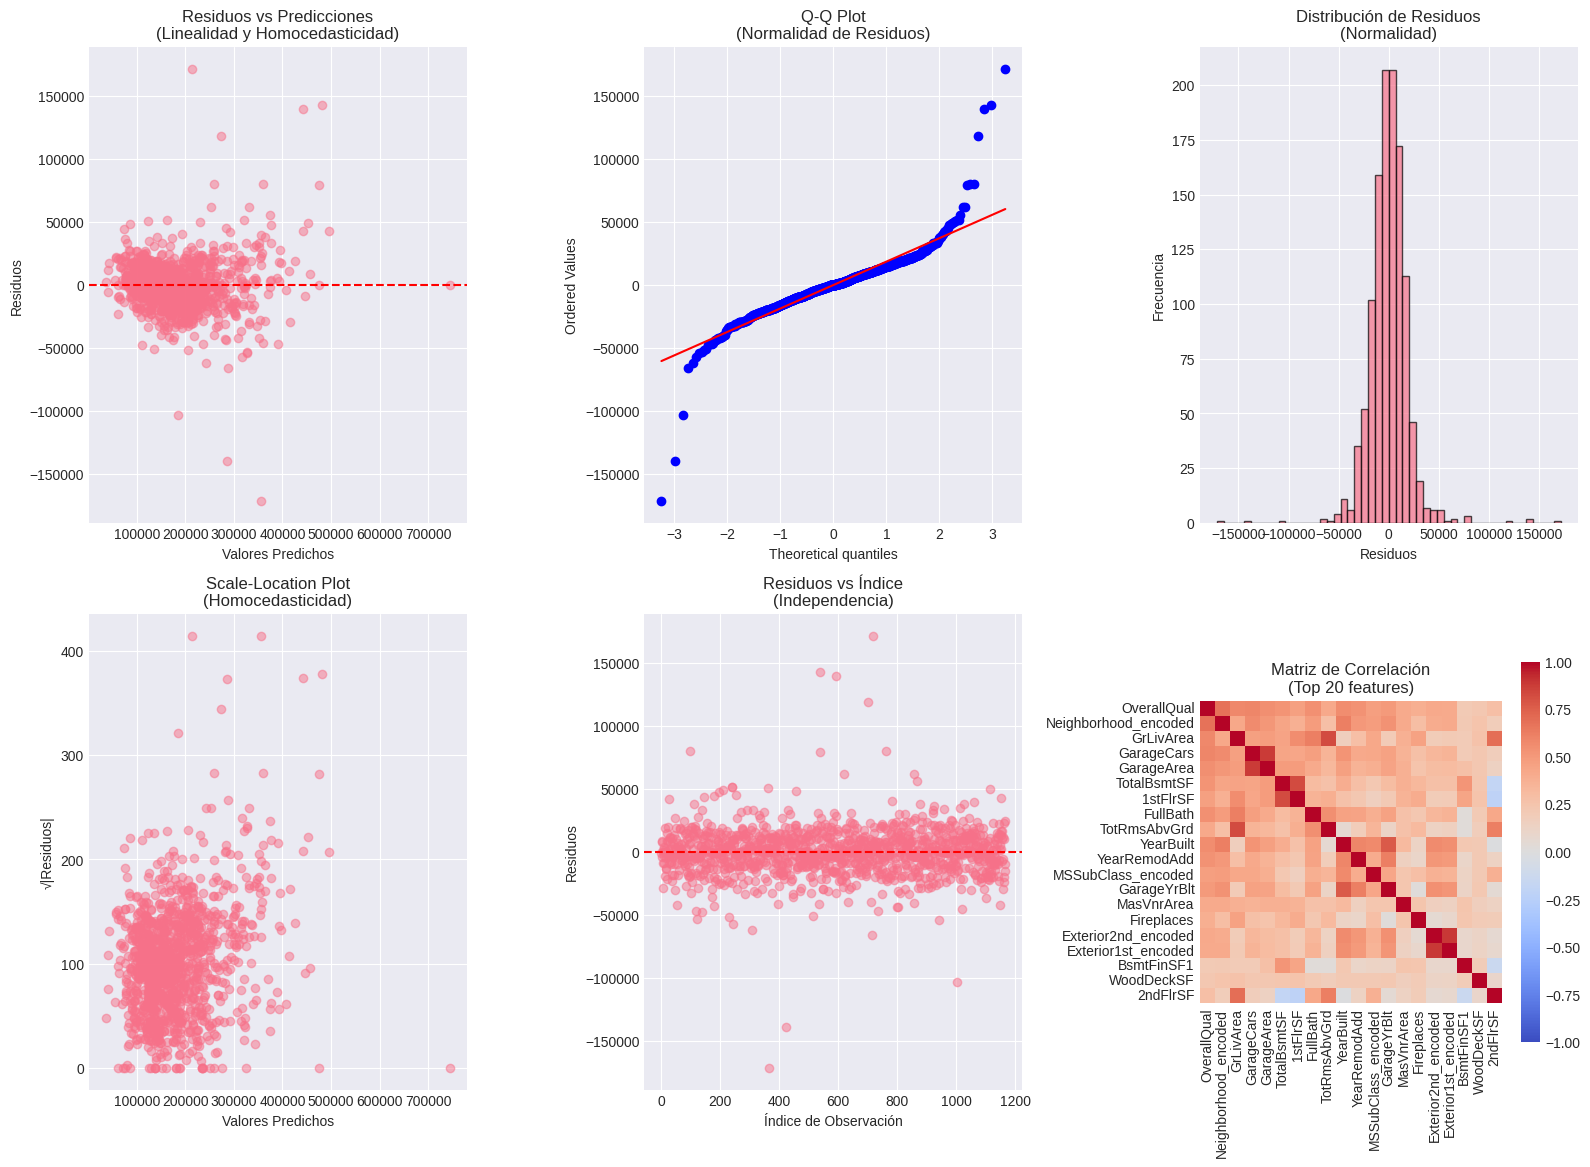

In [108]:
# ============================================================================
# VERIFICACIÓN DE SUPUESTOS DE REGRESIÓN LINEAL
# ============================================================================
print("\n" + "=" * 80)
print("7. VERIFICACIÓN DE SUPUESTOS DE REGRESIÓN LINEAL")
print("=" * 80)

"""
Los modelos de regresión lineal asumen:

1. LINEALIDAD: Relación lineal entre X e y
2. NORMALIDAD: Los residuos siguen una distribución normal
3. HOMOCEDASTICIDAD: Varianza constante de los residuos
4. INDEPENDENCIA: Residuos no correlacionados
5. NO MULTICOLINEALIDAD: Variables predictoras no altamente correlacionadas
"""

# Entrenar modelo base para verificar supuestos
lr_base = LinearRegression()
lr_base.fit(X_train_scaled, y_train)
y_pred_train = lr_base.predict(X_train_scaled)
residuals = y_train - y_pred_train

print("\n--- SUPUESTO DE LINEALIDAD ---")
print("""
El supuesto de linealidad requiere que la relación entre las variables
independientes y la dependiente sea lineal.

Verificación: Gráfico de valores predichos vs residuos
- Si hay linealidad: Los residuos se distribuyen aleatoriamente alrededor de 0
- Si NO hay linealidad: Se observa un patrón (curva, embudo, etc.)
""")

#  SUPUESTO DE NORMALIDAD DE RESIDUOS
print("\n--- SUPUESTO DE NORMALIDAD DE RESIDUOS ---")
print("""
Los residuos deben seguir una distribución normal.

Tests estadísticos:
- Shapiro-Wilk: H0 = los datos siguen distribución normal
- Anderson-Darling: Similar a Shapiro-Wilk
- D'Agostino-Pearson: Basado en skewness y kurtosis

Si p-value < 0.05 → Rechazamos H0 → NO hay normalidad
""")

# Test de Shapiro-Wilk (para muestras pequeñas)
if len(residuals) < 5000:
    stat_shapiro, p_shapiro = shapiro(residuals)
    print(f"\nTest de Shapiro-Wilk:")
    print(f"  Estadístico: {stat_shapiro:.6f}")
    print(f"  P-value: {p_shapiro:.6f}")
    if p_shapiro < 0.05:
        print("  → Los residuos NO siguen una distribución normal (rechazamos H0)")
    else:
        print("  → Los residuos siguen una distribución normal (no rechazamos H0)")

# Test de normalidad de D'Agostino-Pearson
stat_normal, p_normal = normaltest(residuals)
print(f"\nTest de D'Agostino-Pearson:")
print(f"  Estadístico: {stat_normal:.6f}")
print(f"  P-value: {p_normal:.6f}")
if p_normal < 0.05:
    print("  → Los residuos NO siguen una distribución normal")
else:
    print("  → Los residuos siguen una distribución normal")

#  SUPUESTO DE HOMOCEDASTICIDAD
print("\n--- SUPUESTO DE HOMOCEDASTICIDAD ---")
print("""
La varianza de los residuos debe ser constante a lo largo de todos los
valores de las variables independientes.

Heterocedasticidad indica que la varianza cambia (forma de embudo en gráficos).
Esto puede afectar la eficiencia de las estimaciones y los intervalos de confianza.
""")

# Test de Breusch-Pagan simulado
residuals_squared = residuals ** 2
correlation = np.corrcoef(y_pred_train, residuals_squared)[0, 1]
print(f"\nCorrelación entre predicciones y residuos²: {correlation:.6f}")
if abs(correlation) < 0.1:
    print("  → Evidencia de homocedasticidad (varianza constante)")
else:
    print("  → Posible heterocedasticidad (varianza no constante)")

# SUPUESTO DE NO MULTICOLINEALIDAD
print("\n--- SUPUESTO DE NO MULTICOLINEALIDAD ---")
print("""
Las variables independientes no deben estar altamente correlacionadas entre sí.

Multicolinealidad causa:
- Coeficientes inestables
- Errores estándar grandes
- Dificultad para interpretar efectos individuales

VIF (Variance Inflation Factor):
- VIF = 1: No correlación
- VIF > 5: Multicolinealidad moderada
- VIF > 10: Multicolinealidad severa
""")

# Calcular matriz de correlación para variables numéricas originales
numeric_cols_original = X_train_ohe.select_dtypes(include=[np.number]).columns
correlation_matrix = X_train_ohe[numeric_cols_original].corr()

# Encontrar pares altamente correlacionados
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"\nPares de variables con correlación |r| > 0.8: {len(high_corr_pairs)}")
if len(high_corr_pairs) > 0:
    print("\nTop 10 pares más correlacionados:")
    for i, (var1, var2, corr) in enumerate(sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]):
        print(f"  {i+1}. {var1} <-> {var2}: r = {corr:.3f}")
    print("  → Advertencia: Alta multicolinealidad detectada")
else:
    print("  → No se detectó multicolinealidad severa")

# Crear visualizaciones de supuestos
fig = plt.figure(figsize=(16, 12))

# 1. Residuos vs Predicciones (Linealidad y Homocedasticidad)
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(y_pred_train, residuals, alpha=0.5)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Valores Predichos')
ax1.set_ylabel('Residuos')
ax1.set_title('Residuos vs Predicciones\n(Linealidad y Homocedasticidad)')

# 2. Q-Q Plot (Normalidad)
ax2 = plt.subplot(2, 3, 2)
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot\n(Normalidad de Residuos)')

# 3. Histograma de Residuos (Normalidad)
ax3 = plt.subplot(2, 3, 3)
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax3.set_xlabel('Residuos')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de Residuos\n(Normalidad)')

# 4. Scale-Location (Homocedasticidad)
ax4 = plt.subplot(2, 3, 4)
ax4.scatter(y_pred_train, np.sqrt(np.abs(residuals)), alpha=0.5)
ax4.set_xlabel('Valores Predichos')
ax4.set_ylabel('√|Residuos|')
ax4.set_title('Scale-Location Plot\n(Homocedasticidad)')

# 5. Residuos vs Índice (Independencia)
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(range(len(residuals)), residuals, alpha=0.5)
ax5.axhline(y=0, color='r', linestyle='--')
ax5.set_xlabel('Índice de Observación')
ax5.set_ylabel('Residuos')
ax5.set_title('Residuos vs Índice\n(Independencia)')

# 6. Mapa de calor de correlaciones
ax6 = plt.subplot(2, 3, 6)
# Seleccionar top 20 variables numéricas más correlacionadas con el target
if len(numeric_cols_original) > 20:
    # Calcular correlación con target
    target_corr = X_train_ohe[numeric_cols_original].corrwith(y_train).abs().sort_values(ascending=False)
    top_features = target_corr.head(20).index
    corr_subset = X_train_ohe[top_features].corr()
else:
    corr_subset = correlation_matrix

sns.heatmap(corr_subset, cmap='coolwarm', center=0, square=True, ax=ax6,
            cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
ax6.set_title('Matriz de Correlación\n(Top 20 features)')

plt.tight_layout()

print("\n✓ Gráfico guardado: 04_supuestos_regresion.png")

#Modelado y evaluacion

In [111]:
# ============================================================================
# MODELADO Y EVALUACIÓN
# ============================================================================
print("\n" + "=" * 80)
print("MODELADO Y EVALUACIÓN")
print("=" * 80)

"""
MODELOS A COMPARAR:

1. REGRESIÓN LINEAL SIMPLE:
   - Minimiza: Σ(y - ŷ)²
   - Sin regularización
   - Puede sufrir overfitting con muchas variables

2. REGRESIÓN RIDGE (L2):
   - Minimiza: Σ(y - ŷ)² + α·Σβ²
   - Penaliza coeficientes grandes
   - Reduce todos los coeficientes pero no los elimina
   - Buena para multicolinealidad

3. REGRESIÓN LASSO (L1):
   - Minimiza: Σ(y - ŷ)² + α·Σ|β|
   - Puede reducir coeficientes a exactamente 0
   - Realiza selección de variables automática
   - Útil cuando hay muchas variables irrelevantes
"""

# Regresión Lineal Simple
print("\n--- REGRESIÓN LINEAL SIMPLE ---")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_train_lr = lr.predict(X_train_scaled)
y_pred_test_lr = lr.predict(X_test_scaled)

# Métricas
mae_train_lr = mean_absolute_error(y_train, y_pred_train_lr)
mse_train_lr = mean_squared_error(y_train, y_pred_train_lr)
rmse_train_lr = np.sqrt(mse_train_lr)
r2_train_lr = r2_score(y_train, y_pred_train_lr)

mae_test_lr = mean_absolute_error(y_test, y_pred_test_lr)
mse_test_lr = mean_squared_error(y_test, y_pred_test_lr)
rmse_test_lr = np.sqrt(mse_test_lr)
r2_test_lr = r2_score(y_test, y_pred_test_lr)

print("\nMétricas en Entrenamiento:")
print(f"  MAE:  ${mae_train_lr:,.2f}")
print(f"  MSE:  {mse_train_lr:,.2f}")
print(f"  RMSE: ${rmse_train_lr:,.2f}")
print(f"  R²:   {r2_train_lr:.4f}")

print("\nMétricas en Prueba:")
print(f"  MAE:  ${mae_test_lr:,.2f}")
print(f"  MSE:  {mse_test_lr:,.2f}")
print(f"  RMSE: ${rmse_test_lr:,.2f}")
print(f"  R²:   {r2_test_lr:.4f}")

# Regresión Ridge
print("\n--- REGRESIÓN RIDGE (con GridSearchCV) ---")
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2', n_jobs=-1)
ridge_cv.fit(X_train_scaled, y_train)

best_ridge = ridge_cv.best_estimator_
print(f"\nMejor alpha: {ridge_cv.best_params_['alpha']}")
print(f"Mejor R² (CV): {ridge_cv.best_score_:.4f}")

y_pred_train_ridge = best_ridge.predict(X_train_scaled)
y_pred_test_ridge = best_ridge.predict(X_test_scaled)

mae_train_ridge = mean_absolute_error(y_train, y_pred_train_ridge)
mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
rmse_train_ridge = np.sqrt(mse_train_ridge)
r2_train_ridge = r2_score(y_train, y_pred_train_ridge)

mae_test_ridge = mean_absolute_error(y_test, y_pred_test_ridge)
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
rmse_test_ridge = np.sqrt(mse_test_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

print("\nMétricas en Entrenamiento:")
print(f"  MAE:  ${mae_train_ridge:,.2f}")
print(f"  MSE:  {mse_train_ridge:,.2f}")
print(f"  RMSE: ${rmse_train_ridge:,.2f}")
print(f"  R²:   {r2_train_ridge:.4f}")

print("\nMétricas en Prueba:")
print(f"  MAE:  ${mae_test_ridge:,.2f}")
print(f"  MSE:  {mse_test_ridge:,.2f}")
print(f"  RMSE: ${rmse_test_ridge:,.2f}")
print(f"  R²:   {r2_test_ridge:.4f}")

# Regresión Lasso
print("\n--- REGRESIÓN LASSO (con GridSearchCV) ---")
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', n_jobs=-1)
lasso_cv.fit(X_train_scaled, y_train)

best_lasso = lasso_cv.best_estimator_
print(f"\nMejor alpha: {lasso_cv.best_params_['alpha']}")
print(f"Mejor R² (CV): {lasso_cv.best_score_:.4f}")

y_pred_train_lasso = best_lasso.predict(X_train_scaled)
y_pred_test_lasso = best_lasso.predict(X_test_scaled)

mae_train_lasso = mean_absolute_error(y_train, y_pred_train_lasso)
mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
rmse_train_lasso = np.sqrt(mse_train_lasso)
r2_train_lasso = r2_score(y_train, y_pred_train_lasso)

mae_test_lasso = mean_absolute_error(y_test, y_pred_test_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)
rmse_test_lasso = np.sqrt(mse_test_lasso)
r2_test_lasso = r2_score(y_test, y_pred_test_lasso)

print("\nMétricas en Entrenamiento:")
print(f"  MAE:  ${mae_train_lasso:,.2f}")
print(f"  MSE:  {mse_train_lasso:,.2f}")
print(f"  RMSE: ${rmse_train_lasso:,.2f}")
print(f"  R²:   {r2_train_lasso:.4f}")

print("\nMétricas en Prueba:")
print(f"  MAE:  ${mae_test_lasso:,.2f}")
print(f"  MSE:  {mse_test_lasso:,.2f}")
print(f"  RMSE: ${rmse_test_lasso:,.2f}")
print(f"  R²:   {r2_test_lasso:.4f}")

# Variables seleccionadas por Lasso
lasso_coef = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': best_lasso.coef_
})
non_zero_features = lasso_coef[lasso_coef['Coefficient'] != 0]
print(f"\nVariables seleccionadas por Lasso: {len(non_zero_features)} de {len(lasso_coef)}")


MODELADO Y EVALUACIÓN

--- REGRESIÓN LINEAL SIMPLE ---

Métricas en Entrenamiento:
  MAE:  $13,278.97
  MSE:  402,753,384.53
  RMSE: $20,068.72
  R²:   0.9325

Métricas en Prueba:
  MAE:  $898,979.17
  MSE:  825,000,376,424.16
  RMSE: $908,295.31
  R²:   -106.5574

--- REGRESIÓN RIDGE (con GridSearchCV) ---

Mejor alpha: 1000
Mejor R² (CV): 0.7918

Métricas en Entrenamiento:
  MAE:  $17,498.29
  MSE:  862,792,499.94
  RMSE: $29,373.33
  R²:   0.8553

Métricas en Prueba:
  MAE:  $20,741.15
  MSE:  1,287,498,757.75
  RMSE: $35,881.73
  R²:   0.8321

--- REGRESIÓN LASSO (con GridSearchCV) ---

Mejor alpha: 1000
Mejor R² (CV): 0.7355

Métricas en Entrenamiento:
  MAE:  $16,486.03
  MSE:  673,142,783.19
  RMSE: $25,945.00
  R²:   0.8871

Métricas en Prueba:
  MAE:  $18,625.49
  MSE:  995,920,006.73
  RMSE: $31,558.20
  R²:   0.8702

Variables seleccionadas por Lasso: 81 de 206


#Comparacion de modelos


COMPARACIÓN DE MODELOS

TABLA COMPARATIVA DE MODELOS
           Modelo    MAE_Train      MAE_Test   RMSE_Train     RMSE_Test  R2_Train     R2_Test
Linear Regression 13278.969186 898979.170604 20068.716564 908295.313444  0.932475 -106.557404
            Ridge 17498.290187  20741.148227 29373.329739  35881.732926  0.855347    0.832146
            Lasso 16486.029344  18625.492640 25944.995340  31558.200309  0.887143    0.870159

🏆 MEJOR MODELO: Lasso
   R² en Test: 0.8702
   RMSE en Test: $31,558.20


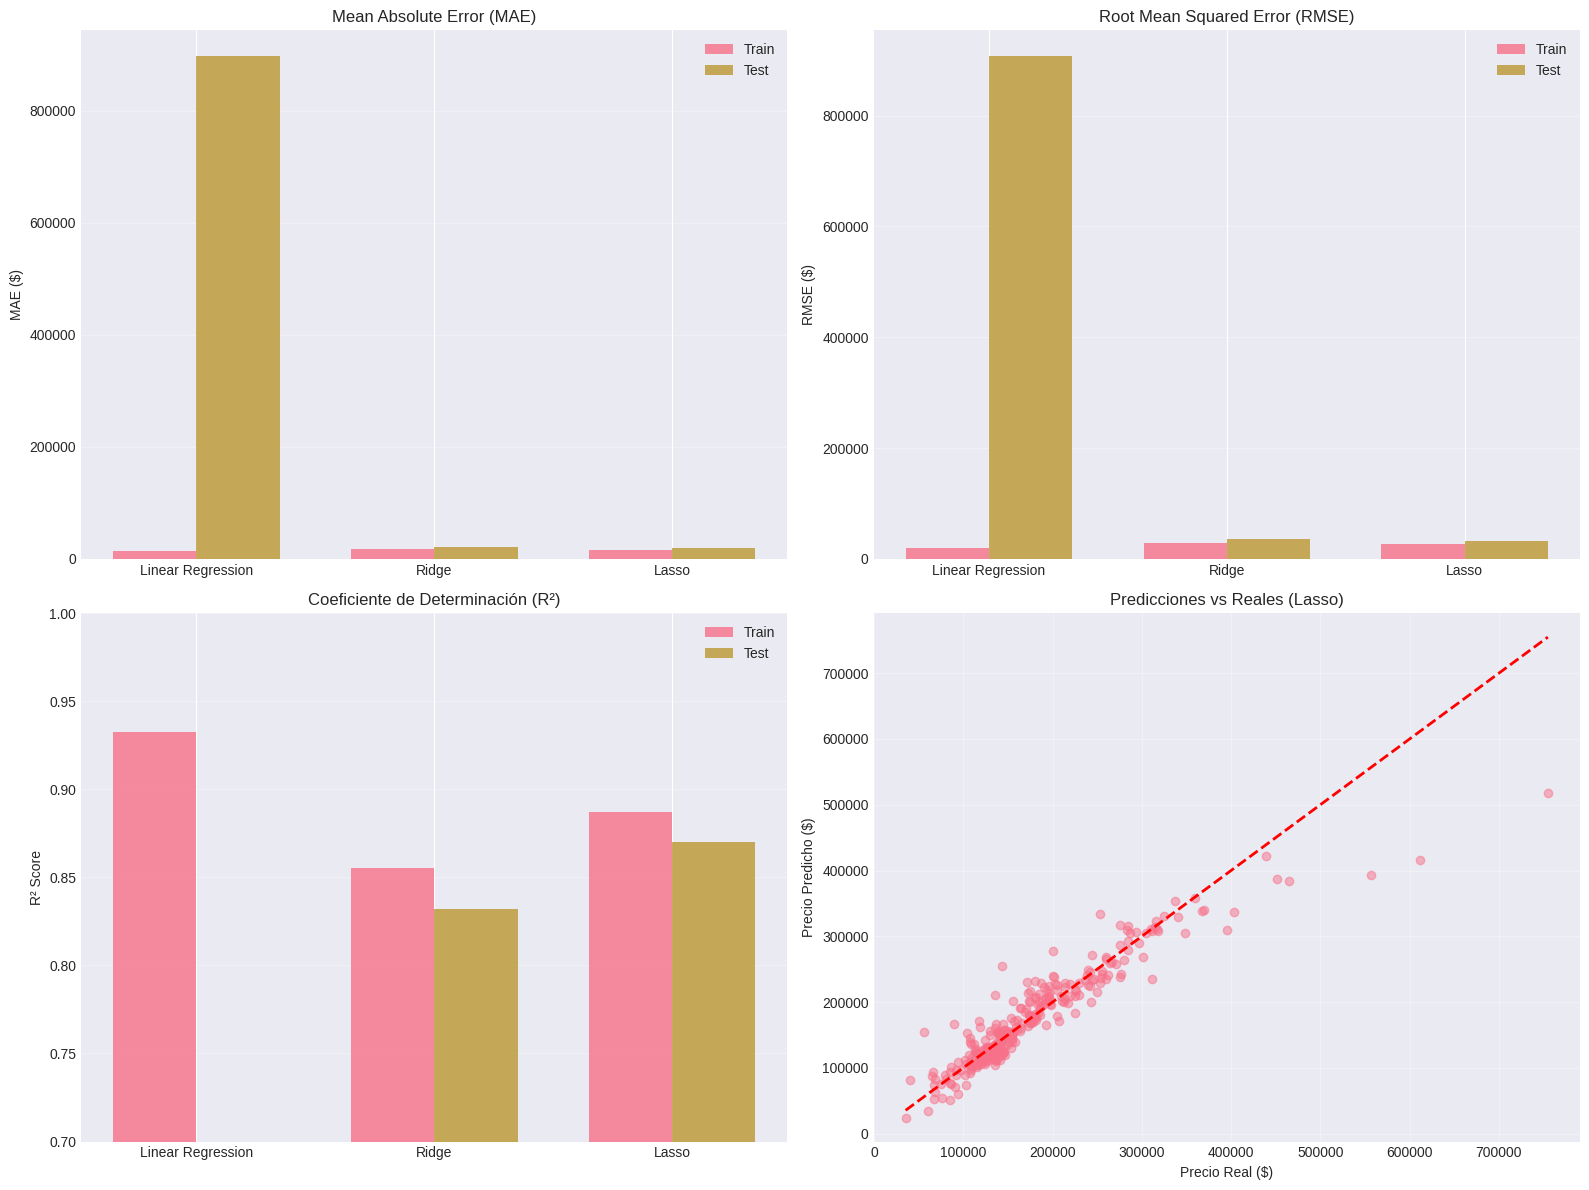

In [112]:
# ============================================================================
# COMPARACIÓN DE MODELOS
# ============================================================================
print("\n" + "=" * 80)
print("COMPARACIÓN DE MODELOS")
print("=" * 80)

# Crear tabla comparativa
comparison = pd.DataFrame({
    'Modelo': ['Linear Regression', 'Ridge', 'Lasso'],
    'MAE_Train': [mae_train_lr, mae_train_ridge, mae_train_lasso],
    'MAE_Test': [mae_test_lr, mae_test_ridge, mae_test_lasso],
    'RMSE_Train': [rmse_train_lr, rmse_train_ridge, rmse_train_lasso],
    'RMSE_Test': [rmse_test_lr, rmse_test_ridge, rmse_test_lasso],
    'R2_Train': [r2_train_lr, r2_train_ridge, r2_train_lasso],
    'R2_Test': [r2_test_lr, r2_test_ridge, r2_test_lasso]
})

print("\n" + "="*100)
print("TABLA COMPARATIVA DE MODELOS")
print("="*100)
print(comparison.to_string(index=False))
print("="*100)

# Identificar mejor modelo
best_model_idx = comparison['R2_Test'].idxmax()
best_model_name = comparison.loc[best_model_idx, 'Modelo']
best_r2 = comparison.loc[best_model_idx, 'R2_Test']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   R² en Test: {best_r2:.4f}")
print(f"   RMSE en Test: ${comparison.loc[best_model_idx, 'RMSE_Test']:,.2f}")

# Visualizar comparación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de MAE
ax1 = axes[0, 0]
x = np.arange(len(comparison))
width = 0.35
ax1.bar(x - width/2, comparison['MAE_Train'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, comparison['MAE_Test'], width, label='Test', alpha=0.8)
ax1.set_ylabel('MAE ($)')
ax1.set_title('Mean Absolute Error (MAE)')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison['Modelo'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Comparación de RMSE
ax2 = axes[0, 1]
ax2.bar(x - width/2, comparison['RMSE_Train'], width, label='Train', alpha=0.8)
ax2.bar(x + width/2, comparison['RMSE_Test'], width, label='Test', alpha=0.8)
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Root Mean Squared Error (RMSE)')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison['Modelo'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Comparación de R²
ax3 = axes[1, 0]
ax3.bar(x - width/2, comparison['R2_Train'], width, label='Train', alpha=0.8)
ax3.bar(x + width/2, comparison['R2_Test'], width, label='Test', alpha=0.8)
ax3.set_ylabel('R² Score')
ax3.set_title('Coeficiente de Determinación (R²)')
ax3.set_xticks(x)
ax3.set_xticklabels(comparison['Modelo'])
ax3.legend()
ax3.set_ylim([0.7, 1.0])
ax3.grid(axis='y', alpha=0.3)

# 4. Predicciones vs Reales (mejor modelo)
ax4 = axes[1, 1]
if best_model_name == 'Linear Regression':
    y_pred_best = y_pred_test_lr
elif best_model_name == 'Ridge':
    y_pred_best = y_pred_test_ridge
else:
    y_pred_best = y_pred_test_lasso

ax4.scatter(y_test, y_pred_best, alpha=0.5)
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax4.set_xlabel('Precio Real ($)')
ax4.set_ylabel('Precio Predicho ($)')
ax4.set_title(f'Predicciones vs Reales ({best_model_name})')
ax4.grid(alpha=0.3)

plt.tight_layout()



#Analisis de coeficientes


10. ANÁLISIS DE COEFICIENTES

Top 20 variables más importantes (Lasso):
              Feature   Coefficient  Abs_Coefficient
            GrLivArea  22597.070079     22597.070079
 Neighborhood_encoded  15228.573005     15228.573005
          OverallQual  14668.121505     14668.121505
            PoolQC_Gd -11211.855976     11211.855976
       KitchenQual_TA  -7068.353013      7068.353013
          BsmtQual_Gd  -7057.331517      7057.331517
       KitchenQual_Gd  -6142.617004      6142.617004
             PoolArea   5696.965082      5696.965082
      Condition2_PosN  -5309.538178      5309.538178
          TotalBsmtSF   5022.825622      5022.825622
          OverallCond   4819.518226      4819.518226
           GarageCars   4761.705372      4761.705372
SaleCondition_Partial   4653.209509      4653.209509
          BsmtQual_TA  -4548.978489      4548.978489
           BsmtFinSF1   4387.049918      4387.049918
         KitchenAbvGr  -4071.216327      4071.216327
      BsmtExposure_Gd   36

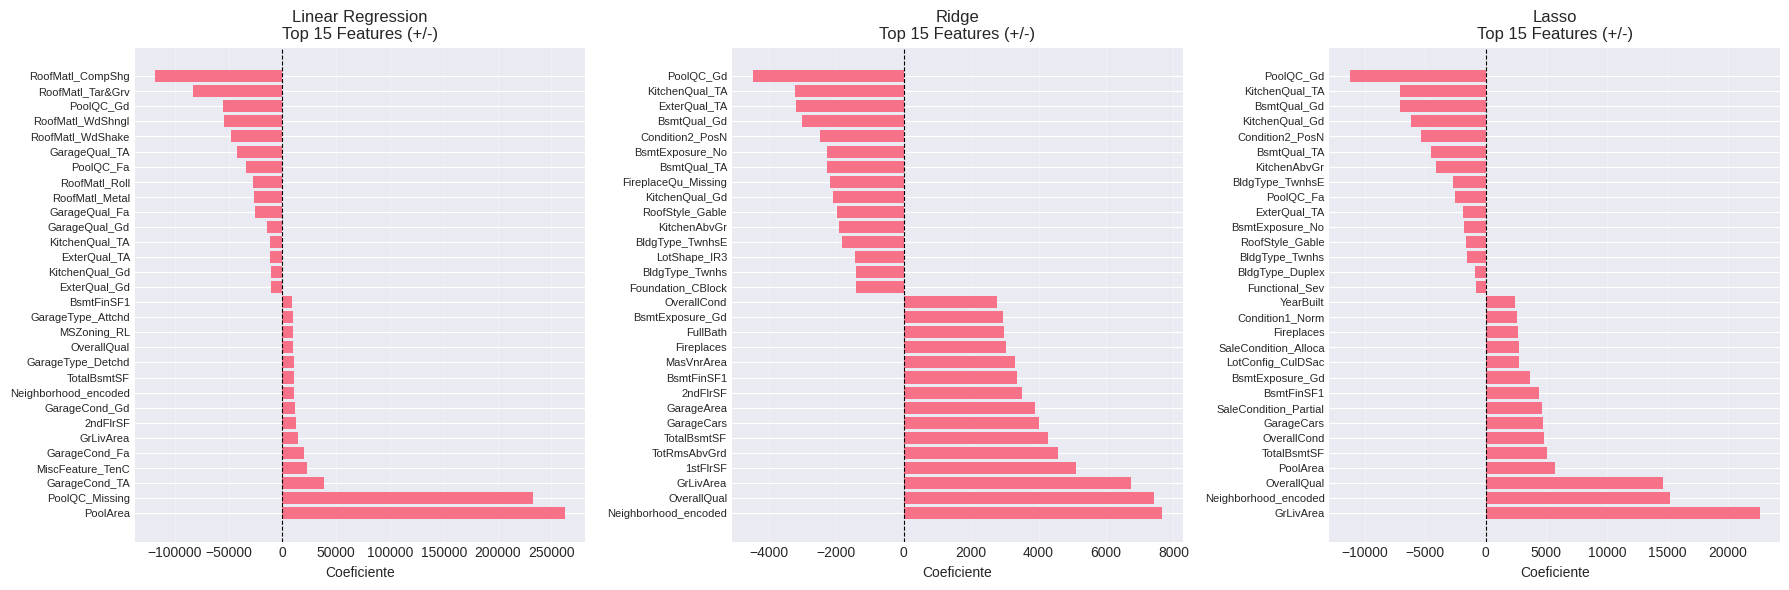

In [84]:
# ============================================================================
# ANÁLISIS DE COEFICIENTES
# ============================================================================
print("\n" + "=" * 80)
print("ANÁLISIS DE COEFICIENTES")
print("=" * 80)

# Coeficientes del mejor modelo
if best_model_name == 'Linear Regression':
    best_model = lr
elif best_model_name == 'Ridge':
    best_model = best_ridge
else:
    best_model = best_lasso

coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': best_model.coef_
})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print(f"\nTop 20 variables más importantes ({best_model_name}):")
print(coef_df.head(20).to_string(index=False))

# Visualizar coeficientes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Coeficientes para cada modelo
for idx, (model, name) in enumerate([(lr, 'Linear Regression'),
                                       (best_ridge, 'Ridge'),
                                       (best_lasso, 'Lasso')]):
    coef_temp = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Coefficient': model.coef_
    })
    coef_temp = coef_temp.sort_values('Coefficient', ascending=False)

    # Top 15 positivos y negativos
    top_features = pd.concat([coef_temp.head(15), coef_temp.tail(15)])

    axes[idx].barh(range(len(top_features)), top_features['Coefficient'])
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features['Feature'], fontsize=8)
    axes[idx].set_xlabel('Coeficiente')
    axes[idx].set_title(f'{name}\nTop 15 Features (+/-)')
    axes[idx].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
